In [1]:
#load the necessary modules
import pandas as pd
import numpy as np
import datetime, math
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import os
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import svm, preprocessing
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, classification_report

from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.utils import to_categorical

from keras.utils.vis_utils import plot_model

Using TensorFlow backend.
/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/U

In [2]:
# loaded the csv file
df_sensor = pd.read_csv("../ten-datasets/sensor.csv", parse_dates=['timestamp'])
df_sensor.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [3]:
df_sensor.machine_status.unique()

array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)

In [4]:
# include the timestamp as one of the feature to train the model

def convert_datetime(x):
    return x.timestamp()

df_sensor['timestamp'] = df_sensor[['timestamp']].applymap(convert_datetime)

df_sensor = df_sensor.drop(['Unnamed: 0'], axis=1)
df_sensor.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,1.522541e+09,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1.522541e+09,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,1.522541e+09,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,1.522541e+09,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,1.522541e+09,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [5]:
for val in df_sensor.columns[1:-1]:
    df_sensor[val] = df_sensor[val].fillna(df_sensor[val].mean())

In [6]:
df_groupby = df_sensor.groupby(['machine_status']).count()
df_groupby['sensor_00']

machine_status
BROKEN             7
NORMAL        205836
RECOVERING     14477
Name: sensor_00, dtype: int64

In [7]:
class_name = ['BROKEN', 'RECOVERING', 'NORMAL']

In [8]:
df_sensor['machine_status'] = df_sensor['machine_status'].replace('BROKEN', 0)
df_sensor['machine_status'] = df_sensor['machine_status'].replace('RECOVERING', 1)
df_sensor['machine_status'] = df_sensor['machine_status'].replace('NORMAL', 2)

In [9]:
X = np.array(df_sensor.iloc[:,0:-1])
X = preprocessing.scale(X)
y = np.array(df_sensor['machine_status'])

In [10]:
print(X.shape)
print(y.shape)

(220320, 52)
(220320,)


In [11]:
# split the training and test dataset with test dataset size is 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [12]:
def model_fit_report(y_values_actual, y_values_predicted, labels, label_name):
       
        
    matrix = confusion_matrix(y_values_actual, y_values_predicted, labels)#labels=lb.classes_
    fig, ax = plt.subplots(figsize=(14, 12))
    sns.heatmap(matrix, annot=True, fmt='d', linewidths=.5, center=0)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.xticks(np.arange(len(labels))+0.5, labels)
    plt.ylabel('True label')
    plt.yticks(np.arange(len(labels))+0.5, labels)
    plt.show()

    print("Classification Report")
    print("")
    print (classification_report(y_values_actual, y_values_predicted))

# LogisticRegression

In [49]:
%%time

clf = LogisticRegression(solver='liblinear')
clf.fit(X_train, y_train)



CPU times: user 14.6 s, sys: 160 ms, total: 14.8 s
Wall time: 14.9 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
accuracy = clf.score(X_train, y_train)
print('model training accuracy: %.4f' %(accuracy))

model training accuracy: 0.9980


In [51]:
accuracy = clf.score(X_test, y_test)
print('model test accuracy: %.4f' %(accuracy))


model test accuracy: 0.9979


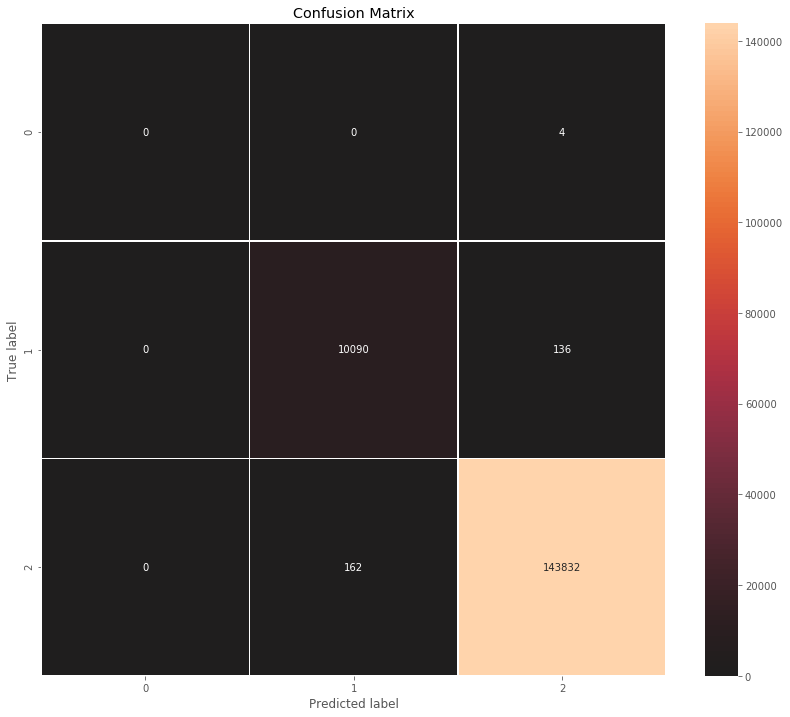

Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.98      0.99      0.99     10226
           2       1.00      1.00      1.00    143994

    accuracy                           1.00    154224
   macro avg       0.66      0.66      0.66    154224
weighted avg       1.00      1.00      1.00    154224



/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


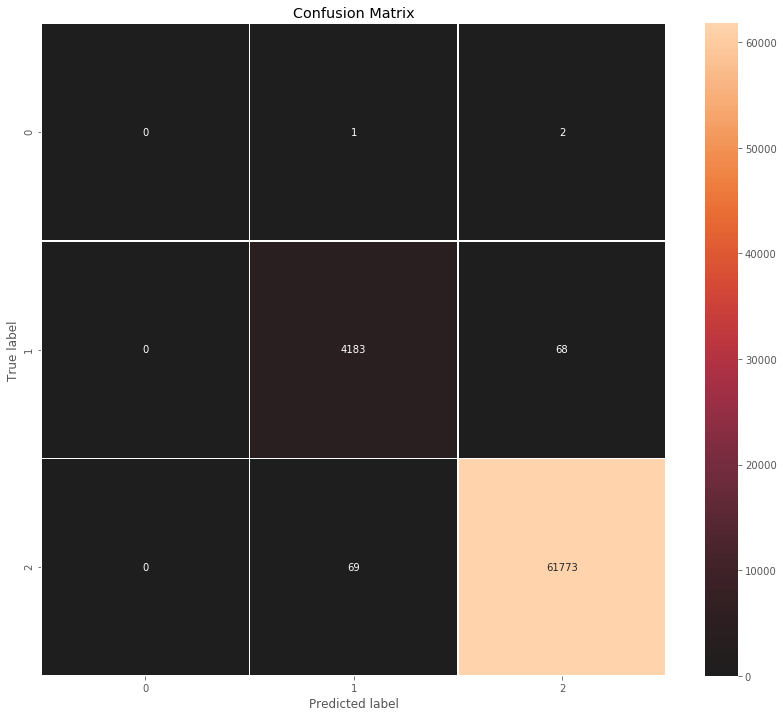

Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.98      0.98      0.98      4251
           2       1.00      1.00      1.00     61842

    accuracy                           1.00     66096
   macro avg       0.66      0.66      0.66     66096
weighted avg       1.00      1.00      1.00     66096



/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:

y_train_predict = clf.predict(X_train)
model_fit_report(y_train, y_train_predict, np.unique(y_train), class_name)

#get results for test dataset
y_test_predict = clf.predict(X_test)
model_fit_report(y_test, y_test_predict, np.unique(y_test), class_name)

# SVM

In [53]:
%%time

clf = svm.SVC()
clf.fit(X_train, y_train)



CPU times: user 35.2 s, sys: 449 ms, total: 35.7 s
Wall time: 35.8 s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [54]:
accuracy = clf.score(X_train, y_train)
print('model training accuracy: %.4f' %(accuracy))

model training accuracy: 0.9998


In [55]:
accuracy = clf.score(X_test, y_test)
print('model test accuracy: %.4f' %(accuracy))

model test accuracy: 0.9996


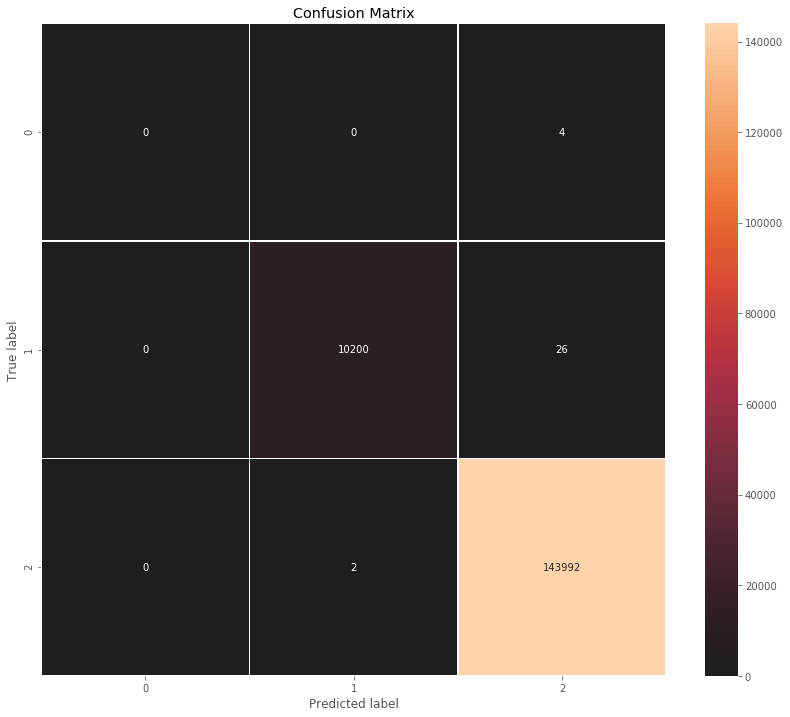

Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       1.00      1.00      1.00     10226
           2       1.00      1.00      1.00    143994

    accuracy                           1.00    154224
   macro avg       0.67      0.67      0.67    154224
weighted avg       1.00      1.00      1.00    154224



/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


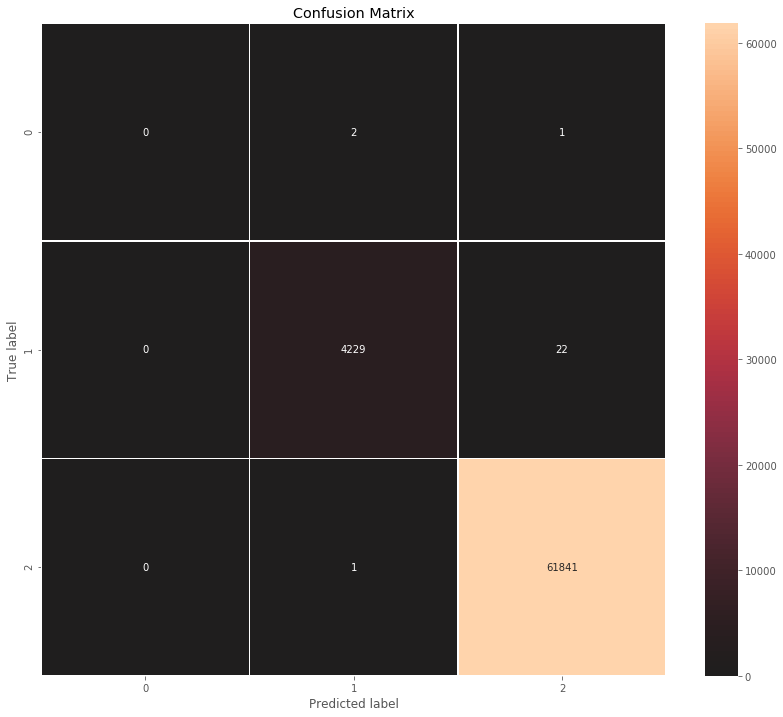

Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       1.00      0.99      1.00      4251
           2       1.00      1.00      1.00     61842

    accuracy                           1.00     66096
   macro avg       0.67      0.66      0.67     66096
weighted avg       1.00      1.00      1.00     66096



/Users/Tommy/opt/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
y_train_predict = clf.predict(X_train)
model_fit_report(y_train, y_train_predict, np.unique(y_train), class_name)

#get results for test dataset
y_test_predict = clf.predict(X_test)
model_fit_report(y_test, y_test_predict, np.unique(y_test), class_name)

# Random Forest

In [57]:
%%time

clf = RandomForestClassifier(criterion='gini', n_estimators=100)
clf.fit(X_train, y_train)



CPU times: user 1min 22s, sys: 570 ms, total: 1min 22s
Wall time: 1min 23s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [58]:
accuracy = clf.score(X_train, y_train)
print('model training accuracy: %.4f' %(accuracy))

model training accuracy: 1.0000


In [59]:
accuracy = clf.score(X_test, y_test)
print('model test accuracy: %.4f' %(accuracy))

model test accuracy: 0.9998


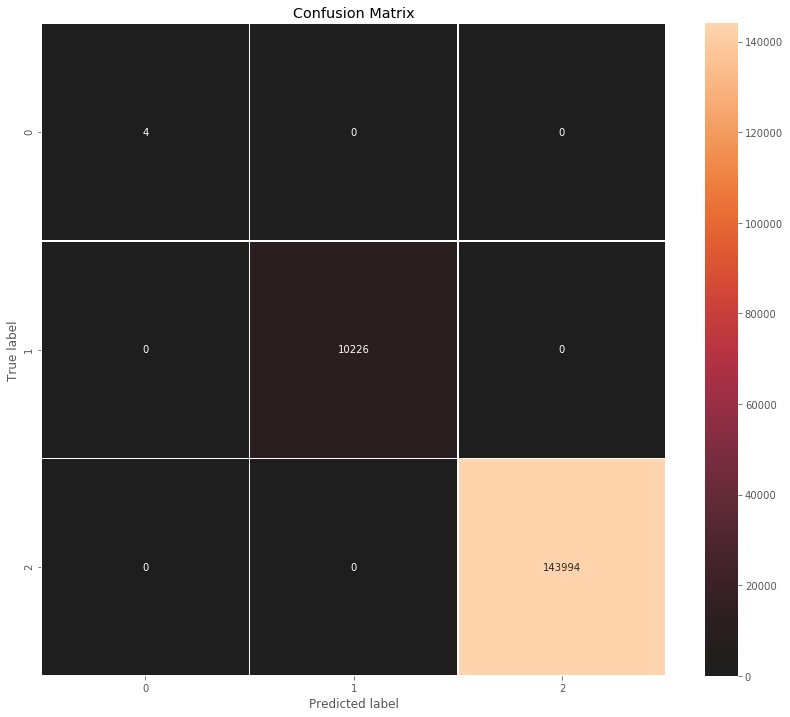

Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00     10226
           2       1.00      1.00      1.00    143994

    accuracy                           1.00    154224
   macro avg       1.00      1.00      1.00    154224
weighted avg       1.00      1.00      1.00    154224



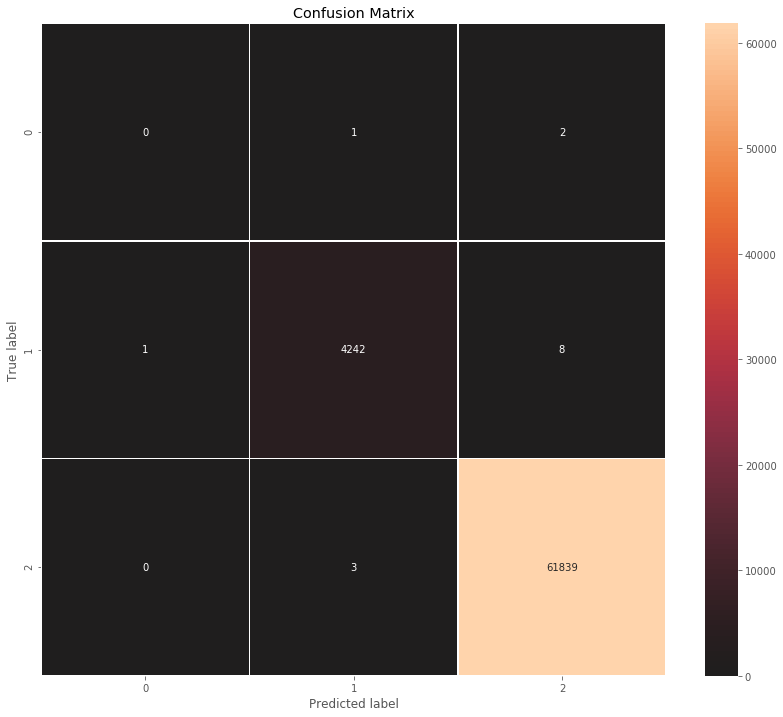

Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       1.00      1.00      1.00      4251
           2       1.00      1.00      1.00     61842

    accuracy                           1.00     66096
   macro avg       0.67      0.67      0.67     66096
weighted avg       1.00      1.00      1.00     66096



In [60]:
y_train_predict = clf.predict(X_train)
model_fit_report(y_train, y_train_predict, np.unique(y_train), class_name)

#get results for test dataset
y_test_predict = clf.predict(X_test)
model_fit_report(y_test, y_test_predict, np.unique(y_test), class_name)

# Deep Learning

In [13]:
X_train.shape

(154224, 52)

In [14]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
y_train_cat.shape

(154224, 3)

In [15]:
def plot_history(history):
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')

    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [16]:
# 2 hidden layers, 100 units
inputs = Input(shape=X_train.shape[1:])
hidden = Dense(100, activation='relu')(inputs)
Dropout(0.25)
hidden = Dense(100, activation='relu')(hidden)
Dropout(0.25)
preds = Dense(3,activation='softmax')(hidden)

model = Model(inputs=inputs,outputs=preds)




Instructions for updating:
Colocations handled automatically by placer.


In [17]:
model.compile(optimizer='sgd' ,loss='mse',metrics=['accuracy'])
#model.compile(optimizer='adam',loss ='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train_cat, batch_size=128, epochs=10, validation_data=(X_test, y_test_cat))

Instructions for updating:
Use tf.cast instead.
Train on 154224 samples, validate on 66096 samples
Epoch 1/10
154224/154224 [==============================] - 3s 17us/step - loss: 0.0282 - accuracy: 0.9720 - val_loss: 0.0086 - val_accuracy: 0.9880
Epoch 2/10
154224/154224 [==============================] - 2s 15us/step - loss: 0.0072 - accuracy: 0.9891 - val_loss: 0.0063 - val_accuracy: 0.9900
Epoch 3/10
154224/154224 [==============================] - 3s 17us/step - loss: 0.0058 - accuracy: 0.9909 - val_loss: 0.0054 - val_accuracy: 0.9914
Epoch 4/10
154224/154224 [==============================] - 3s 17us/step - loss: 0.0051 - accuracy: 0.9920 - val_loss: 0.0048 - val_accuracy: 0.9926
Epoch 5/10
154224/154224 [==============================] - 2s 15us/step - loss: 0.0046 - accuracy: 0.9927 - val_loss: 0.0044 - val_accuracy: 0.9931
Epoch 6/10
154224/154224 [==============================] - 2s 15us/step - loss: 0.0042 - accuracy: 0.9932 - val_loss: 0.0040 - val_accuracy: 0.9935
Epoch 7

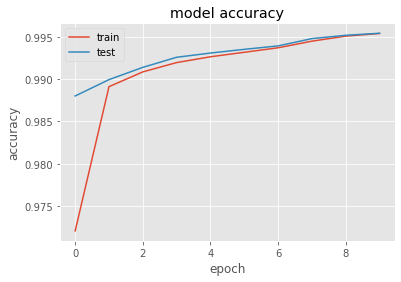

In [19]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

image_name = 'PumpSensor_ann_accuracy.png'
plt.savefig(image_name)

plt.show()

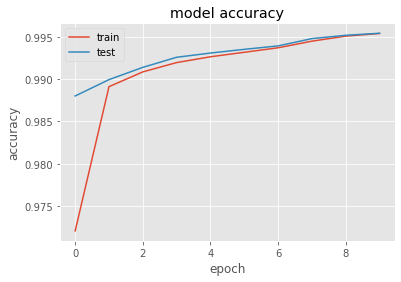

In [20]:
plot_history(history)

In [67]:
# 2 hidden layers, 100 units
inputs = Input(shape=X_train.shape[1:])
hidden = Dense(100, activation='relu')(inputs)
Dropout(0.25)
hidden = Dense(100, activation='relu')(hidden)
Dropout(0.25)
preds = Dense(3,activation='softmax')(hidden)

model = Model(inputs=inputs,outputs=preds)

In [68]:
#model.compile(optimizer='sgd' ,loss='mse',metrics=['accuracy'])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test))

Train on 154224 samples, validate on 66096 samples
Epoch 1/10
154224/154224 [==============================] - 3s 20us/step - loss: 0.0180 - accuracy: 0.9947 - val_loss: 0.0045 - val_accuracy: 0.9984
Epoch 2/10
154224/154224 [==============================] - 3s 18us/step - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.0061 - val_accuracy: 0.9980
Epoch 3/10
154224/154224 [==============================] - 3s 18us/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.0023 - val_accuracy: 0.9994
Epoch 4/10
154224/154224 [==============================] - 3s 19us/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.0039 - val_accuracy: 0.9991
Epoch 5/10
154224/154224 [==============================] - 3s 19us/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0024 - val_accuracy: 0.9993
Epoch 6/10
154224/154224 [==============================] - 3s 19us/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 0.0021 - val_accuracy: 0.9996
Epoch 7/10
154224/154224 [=============================

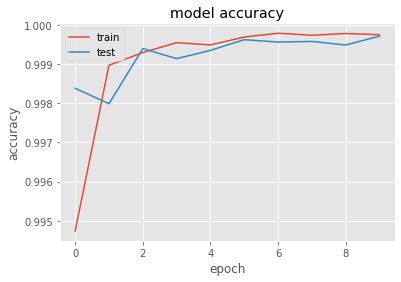

In [69]:
plot_history(history)

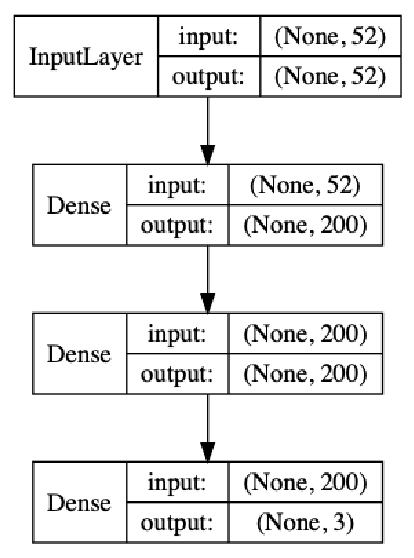

In [70]:
# 2 hidden layers, 200 units
inputs = Input(shape=[52,])
hidden = Dense(200, activation='relu')(inputs)
Dropout(0.25)
hidden = Dense(200, activation='relu')(hidden)
Dropout(0.25)
preds = Dense(y_train_cat.shape[1],activation='softmax')(hidden)

model = Model(inputs=inputs,outputs=preds)


image_name = 'pump_sensor_ann_model.png'
plot_model(model,to_file=image_name,show_shapes=True,show_layer_names=False,rankdir='TB')
plt.figure(figsize=(10,10))
img = plt.imread(image_name)
plt.imshow(img)
plt.axis('off')
plt.show()

In [71]:
model.compile(optimizer='sgd' ,loss='mse',metrics=['accuracy'])
#model.compile(optimizer='adam',loss ='categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train_cat, batch_size=128, epochs=10, validation_data=(X_test, y_test_cat))

Train on 154224 samples, validate on 66096 samples
Epoch 1/10
154224/154224 [==============================] - 4s 23us/step - loss: 0.0267 - accuracy: 0.9706 - val_loss: 0.0075 - val_accuracy: 0.9889
Epoch 2/10
154224/154224 [==============================] - 3s 22us/step - loss: 0.0062 - accuracy: 0.9904 - val_loss: 0.0053 - val_accuracy: 0.9915
Epoch 3/10
154224/154224 [==============================] - 3s 22us/step - loss: 0.0049 - accuracy: 0.9920 - val_loss: 0.0045 - val_accuracy: 0.9926
Epoch 4/10
154224/154224 [==============================] - 3s 22us/step - loss: 0.0042 - accuracy: 0.9929 - val_loss: 0.0040 - val_accuracy: 0.9932
Epoch 5/10
154224/154224 [==============================] - 3s 22us/step - loss: 0.0038 - accuracy: 0.9934 - val_loss: 0.0036 - val_accuracy: 0.9936
Epoch 6/10
154224/154224 [==============================] - 3s 22us/step - loss: 0.0035 - accuracy: 0.9938 - val_loss: 0.0034 - val_accuracy: 0.9941
Epoch 7/10
154224/154224 [=============================

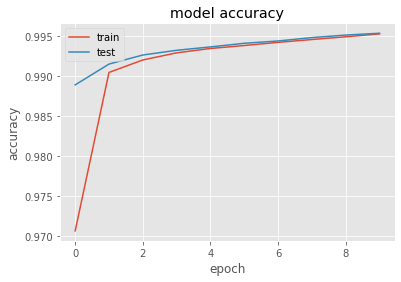

In [72]:
plot_history(history)

In [73]:
# 2 hidden layers, 300 units
inputs = Input(shape=[52,])
hidden = Dense(300, activation='relu')(inputs)
Dropout(0.25)
hidden = Dense(300, activation='relu')(hidden)
Dropout(0.25)
preds = Dense(y_train_cat.shape[1],activation='softmax')(hidden)

model = Model(inputs=inputs,outputs=preds)

In [74]:
model.compile(optimizer='sgd' ,loss='mse',metrics=['accuracy'])
history = model.fit(X_train, y_train_cat, batch_size=128, epochs=10, validation_data=(X_test, y_test_cat))

Train on 154224 samples, validate on 66096 samples
Epoch 1/10
154224/154224 [==============================] - 5s 30us/step - loss: 0.0251 - accuracy: 0.9776 - val_loss: 0.0074 - val_accuracy: 0.9890
Epoch 2/10
154224/154224 [==============================] - 4s 29us/step - loss: 0.0063 - accuracy: 0.9897 - val_loss: 0.0054 - val_accuracy: 0.9910
Epoch 3/10
154224/154224 [==============================] - 4s 29us/step - loss: 0.0050 - accuracy: 0.9919 - val_loss: 0.0045 - val_accuracy: 0.9928
Epoch 4/10
154224/154224 [==============================] - 5s 29us/step - loss: 0.0042 - accuracy: 0.9932 - val_loss: 0.0039 - val_accuracy: 0.9935
Epoch 5/10
154224/154224 [==============================] - 5s 30us/step - loss: 0.0038 - accuracy: 0.9939 - val_loss: 0.0035 - val_accuracy: 0.9941
Epoch 6/10
154224/154224 [==============================] - 5s 30us/step - loss: 0.0034 - accuracy: 0.9946 - val_loss: 0.0032 - val_accuracy: 0.9949
Epoch 7/10
154224/154224 [=============================

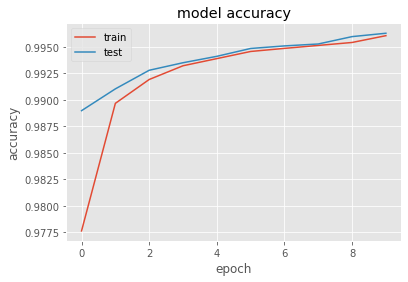

In [75]:
plot_history(history)

In [76]:
# 3 hidden layers, 100 units
inputs = Input(shape=[52,])
hidden = Dense(100, activation='relu')(inputs)
Dropout(0.25)
hidden = Dense(100, activation='relu')(hidden)
Dropout(0.25)
hidden = Dense(100, activation='relu')(hidden)
Dropout(0.25)
preds = Dense(y_train_cat.shape[1],activation='softmax')(hidden)

model = Model(inputs=inputs,outputs=preds)

In [77]:
model.compile(optimizer='sgd' ,loss='mse',metrics=['accuracy'])
history = model.fit(X_train, y_train_cat, batch_size=128, epochs=10, validation_data=(X_test, y_test_cat))

Train on 154224 samples, validate on 66096 samples
Epoch 1/10
154224/154224 [==============================] - 3s 20us/step - loss: 0.0274 - accuracy: 0.9720 - val_loss: 0.0076 - val_accuracy: 0.9887
Epoch 2/10
154224/154224 [==============================] - 3s 19us/step - loss: 0.0066 - accuracy: 0.9895 - val_loss: 0.0058 - val_accuracy: 0.9899
Epoch 3/10
154224/154224 [==============================] - 3s 20us/step - loss: 0.0053 - accuracy: 0.9910 - val_loss: 0.0047 - val_accuracy: 0.9920
Epoch 4/10
154224/154224 [==============================] - 3s 20us/step - loss: 0.0044 - accuracy: 0.9928 - val_loss: 0.0040 - val_accuracy: 0.9933
Epoch 5/10
154224/154224 [==============================] - 3s 19us/step - loss: 0.0039 - accuracy: 0.9935 - val_loss: 0.0036 - val_accuracy: 0.9936
Epoch 6/10
154224/154224 [==============================] - 3s 19us/step - loss: 0.0035 - accuracy: 0.9940 - val_loss: 0.0033 - val_accuracy: 0.9939
Epoch 7/10
154224/154224 [=============================

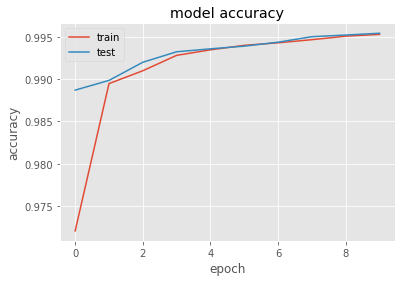

In [78]:
plot_history(history)

In [79]:
# 4 hidden layers, 100 units
inputs = Input(shape=[52,])
hidden = Dense(100, activation='relu')(inputs)
Dropout(0.25)
hidden = Dense(100, activation='relu')(hidden)
Dropout(0.25)
hidden = Dense(100, activation='relu')(hidden)
Dropout(0.25)
hidden = Dense(100, activation='relu')(hidden)
Dropout(0.25)
preds = Dense(y_train_cat.shape[1],activation='softmax')(hidden)

model = Model(inputs=inputs,outputs=preds)

In [80]:
model.compile(optimizer='sgd' ,loss='mse',metrics=['accuracy'])
history = model.fit(X_train, y_train_cat, batch_size=128, epochs=10, validation_data=(X_test, y_test_cat))

Train on 154224 samples, validate on 66096 samples
Epoch 1/10
154224/154224 [==============================] - 4s 24us/step - loss: 0.0452 - accuracy: 0.9452 - val_loss: 0.0075 - val_accuracy: 0.9900
Epoch 2/10
154224/154224 [==============================] - 3s 22us/step - loss: 0.0061 - accuracy: 0.9906 - val_loss: 0.0052 - val_accuracy: 0.9911
Epoch 3/10
154224/154224 [==============================] - 4s 25us/step - loss: 0.0047 - accuracy: 0.9920 - val_loss: 0.0041 - val_accuracy: 0.9927
Epoch 4/10
154224/154224 [==============================] - 4s 24us/step - loss: 0.0038 - accuracy: 0.9936 - val_loss: 0.0035 - val_accuracy: 0.9943
Epoch 5/10
154224/154224 [==============================] - 4s 23us/step - loss: 0.0033 - accuracy: 0.9946 - val_loss: 0.0031 - val_accuracy: 0.9951
Epoch 6/10
154224/154224 [==============================] - 3s 23us/step - loss: 0.0030 - accuracy: 0.9952 - val_loss: 0.0028 - val_accuracy: 0.9954
Epoch 7/10
154224/154224 [=============================

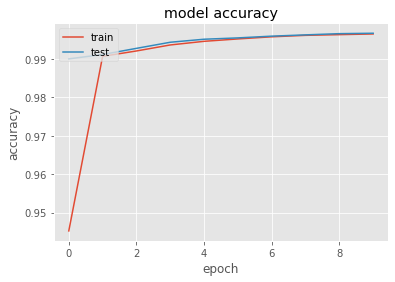

In [81]:
plot_history(history)

# CNN

In [82]:
X_train = X_train[:, :, np.newaxis]
X_train.shape

(154224, 52, 1)

In [83]:
X_test = X_test[:, :, np.newaxis]
X_test.shape

(66096, 52, 1)

In [84]:
from keras.models import Sequential
from keras.layers import Input, Conv1D, Conv2D, BatchNormalization, Activation, MaxPooling1D, MaxPooling2D, Dropout, Flatten, Dense, LSTM

In [85]:
#bn_axis = 3

model = Sequential()

model.add(Conv1D(32, 6, activation='relu', input_shape=X_train.shape[1:], strides=1))
model.add(Conv1D(32, 6))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train_cat.shape[1], activation='softmax'))
model.compile(optimizer='sgd' ,loss='mse',metrics=['accuracy'])
         
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 47, 32)            224       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 42, 32)            6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 32)            0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 14, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 100)               44900     
_________________________________________________________________
dropout_25 (Dropout)         (None, 100)              

In [86]:
history = model.fit(X_train, y_train_cat, batch_size=128, epochs=10, validation_data=(X_test, y_test_cat))

Train on 154224 samples, validate on 66096 samples
Epoch 1/10
154224/154224 [==============================] - 20s 129us/step - loss: 0.0309 - accuracy: 0.9609 - val_loss: 0.0058 - val_accuracy: 0.9894
Epoch 2/10
154224/154224 [==============================] - 19s 126us/step - loss: 0.0076 - accuracy: 0.9874 - val_loss: 0.0053 - val_accuracy: 0.9902
Epoch 3/10
154224/154224 [==============================] - 19s 125us/step - loss: 0.0066 - accuracy: 0.9888 - val_loss: 0.0050 - val_accuracy: 0.9907
Epoch 4/10
154224/154224 [==============================] - 19s 125us/step - loss: 0.0059 - accuracy: 0.9895 - val_loss: 0.0046 - val_accuracy: 0.9915
Epoch 5/10
154224/154224 [==============================] - 19s 125us/step - loss: 0.0056 - accuracy: 0.9902 - val_loss: 0.0042 - val_accuracy: 0.9919
Epoch 6/10
154224/154224 [==============================] - 19s 125us/step - loss: 0.0052 - accuracy: 0.9905 - val_loss: 0.0040 - val_accuracy: 0.9921
Epoch 7/10
154224/154224 [=================

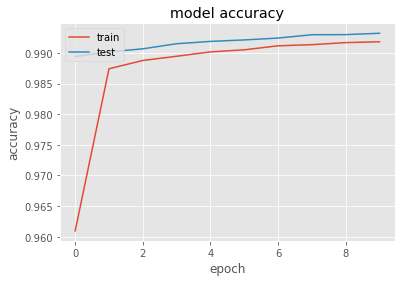

In [87]:
plot_history(history)

In [88]:
model = Sequential()

model.add(Conv1D(32, 6, activation='relu', input_shape=X_train.shape[1:], strides=1))
model.add(Conv1D(32, 6))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train_cat.shape[1], activation='softmax'))
model.compile(optimizer='sgd' ,loss='mse',metrics=['accuracy'])
         
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 47, 32)            224       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 42, 32)            6176      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 14, 32)            0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 14, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 448)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 200)               89800     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)              

In [89]:
history = model.fit(X_train, y_train_cat, batch_size=128, epochs=10, validation_data=(X_test, y_test_cat))

Train on 154224 samples, validate on 66096 samples
Epoch 1/10
154224/154224 [==============================] - 22s 143us/step - loss: 0.0493 - accuracy: 0.9223 - val_loss: 0.0082 - val_accuracy: 0.9885
Epoch 2/10
154224/154224 [==============================] - 22s 140us/step - loss: 0.0105 - accuracy: 0.9833 - val_loss: 0.0064 - val_accuracy: 0.9885
Epoch 3/10
154224/154224 [==============================] - 22s 144us/step - loss: 0.0080 - accuracy: 0.9865 - val_loss: 0.0063 - val_accuracy: 0.9889
Epoch 4/10
154224/154224 [==============================] - 22s 140us/step - loss: 0.0071 - accuracy: 0.9878 - val_loss: 0.0061 - val_accuracy: 0.9892
Epoch 5/10
154224/154224 [==============================] - 22s 141us/step - loss: 0.0069 - accuracy: 0.9880 - val_loss: 0.0059 - val_accuracy: 0.9898
Epoch 6/10
154224/154224 [==============================] - 22s 141us/step - loss: 0.0066 - accuracy: 0.9885 - val_loss: 0.0057 - val_accuracy: 0.9900
Epoch 7/10
154224/154224 [=================

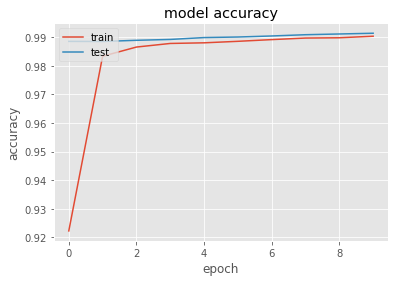

In [90]:
plot_history(history)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 47, 64)            448       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 42, 64)            24640     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 14, 64)            0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 14, 64)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 100)               89700     
_________________________________________________________________
dropout_30 (Dropout)         (None, 100)              

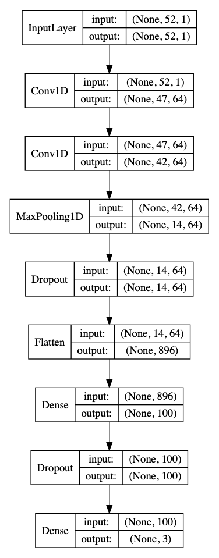

In [91]:
model = Sequential()

model.add(Conv1D(64, 6, activation='relu', input_shape=X_train.shape[1:], strides=1))
model.add(Conv1D(64, 6))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train_cat.shape[1], activation='softmax'))
model.compile(optimizer='sgd' ,loss='mse',metrics=['accuracy'])
         
model.summary()

image_name = 'pump_sensor_cnn_model.png'
plot_model(model,to_file=image_name,show_shapes=True,show_layer_names=False,rankdir='TB')
plt.figure(figsize=(10,10))
img = plt.imread(image_name)
plt.imshow(img)
plt.axis('off')
plt.show()

In [92]:
history = model.fit(X_train, y_train_cat, batch_size=128, epochs=10, validation_data=(X_test, y_test_cat))

Train on 154224 samples, validate on 66096 samples
Epoch 1/10
154224/154224 [==============================] - 40s 257us/step - loss: 0.0310 - accuracy: 0.9585 - val_loss: 0.0059 - val_accuracy: 0.9897
Epoch 2/10
154224/154224 [==============================] - 39s 253us/step - loss: 0.0076 - accuracy: 0.9876 - val_loss: 0.0055 - val_accuracy: 0.9900
Epoch 3/10
154224/154224 [==============================] - 40s 259us/step - loss: 0.0065 - accuracy: 0.9888 - val_loss: 0.0052 - val_accuracy: 0.9906
Epoch 4/10
154224/154224 [==============================] - 40s 259us/step - loss: 0.0061 - accuracy: 0.9893 - val_loss: 0.0050 - val_accuracy: 0.9907
Epoch 5/10
154224/154224 [==============================] - 40s 258us/step - loss: 0.0057 - accuracy: 0.9901 - val_loss: 0.0047 - val_accuracy: 0.9910
Epoch 6/10
154224/154224 [==============================] - 39s 256us/step - loss: 0.0053 - accuracy: 0.9905 - val_loss: 0.0044 - val_accuracy: 0.9914
Epoch 7/10
154224/154224 [=================

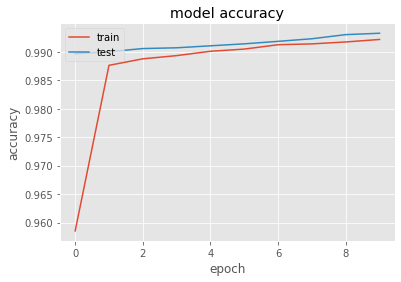

In [93]:
plot_history(history)

# LSTM

In [94]:
lstm_units = 200
num_classes = 3

model = Sequential() 
model.add(LSTM(units = lstm_units,input_shape = (52, 1), dropout=0.25, return_sequences=True)) # 3D tensor with shape (batch_size, timesteps, input_dim).
model.add(LSTM(units = lstm_units, dropout=0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 52, 200)           161600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_40 (Dense)             (None, 3)                 603       
Total params: 483,003
Trainable params: 483,003
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, batch_size=128 ,epochs=10, validation_data=(X_test, y_test))

Train on 154224 samples, validate on 66096 samples
Epoch 1/10
154224/154224 [==============================] - 685s 4ms/step - loss: 0.0927 - accuracy: 0.9728 - val_loss: 0.0261 - val_accuracy: 0.9904
Epoch 2/10
154224/154224 [==============================] - 730s 5ms/step - loss: 0.0783 - accuracy: 0.9777 - val_loss: 0.0259 - val_accuracy: 0.9877
Epoch 3/10
 83456/154224 [===============>..............] - ETA: 5:56 - loss: 0.0718 - accuracy: 0.9798